# [WritingQuality] Easy Feature Analysis (Eng/日本語)

(31-Oct : Title Changed)  
This competition is, make students to write an essay and record all actions using Key-logger, and to predict the score of the essay based on the logged-action information.  
As usual, I'd like to enjoy "Hypothesis and verification" process about what kind of features would contribute the score improvement rather than aiming higher scores, and hence I'm sorry that the score of this notebook is still low.  
The improvement history from various attempt is as the below chart.   
From this result of attempting various features, I guess Teachers may want to say to students as follows.... (LOL)

今回のお題は、生徒にエッセイを書かせてその動作（キー入力、クリック動作等のすべての動作）をキーロガーで記録し、その動作情報をもとにエッセイの採点結果を予測するというものです。  
スコアの高さを目指すよりも、どういった要素がモデル改善に有効なのかの「仮説と検証」を楽しみたいので、毎度のことで恐縮ですがスコアは低くて申し訳ありません。  
いろいろな特徴量を試してみたスコア改善の結果は以下の表のとおりですが、これを見ると、先生はエッセイを書く生徒に以下のように言いたくなるのではないかと思います（笑）

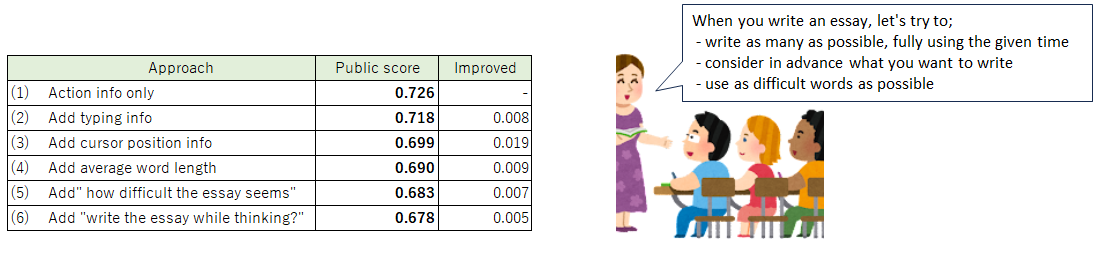


# (1) Baseline

In [1]:
import os
import pandas as pd
import numpy as np
import gc
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgbm
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import nltk
from nltk.tokenize import word_tokenize

pd.set_option("display.max_columns", None)

Let's take alook at Training data first. For each essay(=id), every single detailed action is logged. For example, the first id (001519c8) has 2557 rows, thus we can know it requires 2000+ actions to complete this one essay. 

訓練データを見てみます。各エッセイ（＝id）毎にひとつひとつの詳細な動作が記録されています。試しに最初のid（001519c8）を見てみますと2557行ありますので、このひとつのエッセイを書くのに、それだけの動作がかかったということになります。

In [2]:
train = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
df_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')
df_test = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')

train

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [3]:
train[train["id"]=="001519c8"]

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
2552,001519c8,2553,1781786,1781841,55,Remove/Cut,Backspace,Backspace,q,555,255
2553,001519c8,2554,1781917,1781991,74,Remove/Cut,Backspace,Backspace,q,554,255
2554,001519c8,2555,1782062,1782141,79,Remove/Cut,Backspace,Backspace,q,553,255
2555,001519c8,2556,1782922,1782985,63,Input,q,q,q,554,255


Let's have a quick look at scores data as well. This "score" will be the target of prediction. Looks like the highest score is 6.0 and the lowest is 0.5.  
scoresのデータを見てみます。このscoreが予測対象となりますが、最高で6.0点、最低で0.5点のようです。

In [4]:
display(df_scores)
print("Max : ", df_scores['score'].max(), "     Min : ", df_scores['score'].min())

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0
...,...,...
2466,ffb8c745,3.5
2467,ffbef7e5,4.0
2468,ffccd6fd,1.5
2469,ffec5b38,5.0


Max :  6.0      Min :  0.5


It may be easier to understand down_time and up_time if we imagine the action of Key-pressing, down-time means the time when this user starts to press the key, and up_time means the time when he/she released the key. Therefore, let's take alook at the last(max) up_time which is the last action of writing the essay. The time is in Milliseconds, so let's changed to Minutes and then you can see almost all last action is around 30min. We see some exceptions, but it seems the time limitation for writing the essay is basically 30min.

down_time、up_timeはキーを押す動作をイメージすると分かりやすそうですが、down_timeがキーを押し始めた時間、up_timeがキーを離した時間になります。それぞれのidに対して最後のup_timeがエッセイを書き終えた動作になりますので、その時間を見てみます。時間はミリ秒（1/1000秒）なので、分に換算すると、ほとんどが30分近辺に集中しています。多少それを超えているキー操作もありますが、このエッセイを書く課題は30分を目途に書くことになっていたのではないかと思われます。

<function matplotlib.pyplot.show(close=None, block=None)>

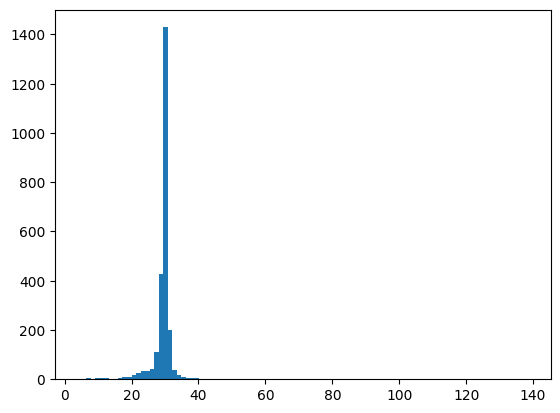

In [5]:
temp = train[['id','up_time']].groupby('id').max()
temp['up_time'] = temp['up_time']/1000/60
plt.hist(temp['up_time'], bins=100)
plt.show

Well, I'd like to start to build the model.  
This competition is basically to predict the score based on the logged "action", hence start to use action-related features.

では、そろそろモデルの構築に入りたいと思います。  
このコンペは各動作をもとにエッセイの点数を予測するというものですので、まずは素直に動作関係のFeatureを使って予測してみたいと思います。  

In [6]:
print(train["activity"].unique())

['Nonproduction' 'Input' 'Remove/Cut' 'Replace'
 'Move From [284, 292] To [282, 290]' 'Move From [287, 289] To [285, 287]'
 'Move From [460, 461] To [465, 466]' 'Paste'
 'Move From [905, 1314] To [907, 1316]'
 'Move From [565, 743] To [669, 847]' 'Move From [669, 847] To [565, 743]'
 'Move From [1041, 1121] To [1496, 1576]'
 'Move From [1455, 1557] To [1323, 1425]'
 'Move From [2268, 2275] To [2247, 2254]'
 'Move From [213, 302] To [902, 991]' 'Move From [0, 158] To [234, 392]'
 'Move From [460, 465] To [925, 930]' 'Move From [810, 906] To [816, 912]'
 'Move From [186, 187] To [184, 185]' 'Move From [140, 272] To [299, 431]'
 'Move From [114, 140] To [272, 298]'
 'Move From [1386, 1450] To [1445, 1509]'
 'Move From [442, 524] To [296, 378]' 'Move From [408, 414] To [390, 396]'
 'Move From [1144, 1147] To [1142, 1145]'
 'Move From [218, 220] To [206, 208]' 'Move From [164, 165] To [153, 154]'
 'Move From [623, 632] To [624, 633]'
 'Move From [747, 960] To [1041, 1254]'
 'Move From [274,

From a look at the unique values of Activity, we see more values than expected. However, many of them are related to Move of "where to where", hence let's put them together into "Move". Then, unique values became the below 6 kinds.

Activityのユニーク値を見てみますと、予想以上に多くの値が出てきましたが、ほとんどはMoveの「どこからどこ」に関するものですので、これらは纏めて「Move」とします。そうするとユニーク値は以下の6種類となりました。

In [7]:
print(train["activity"].str[:4].unique())

['Nonp' 'Inpu' 'Remo' 'Repl' 'Move' 'Past']


For Baseline, let's predict using "time to start writing essay", "time to finish writing", "action time", "word count" and "counts of each activities" as features.  
Below codes are comment-out here, but you will see the public score **0.726** if you remove the comment out. This score itself is not good, but may be ok for the first trial.

Baselineとしては、各エッセイについて「書き始めた時間」「書き終えた時間」「各動作の所要時間」「単語の数」「動作種類ごとの回数」を特徴量として予測してみます。  
コメントアウトしていますが、これを実行するとPublic Scoreは**0.726**となります。他の方が公開しているNotebookのスコアに比べるとかなり悪いですが、まぁ、ここから色々試してみます。

In [8]:
"""
def feature_eng(df) :
    df_train  = df[["id","down_time",]].groupby("id").min()
    df_temp   = df[["id","up_time",]].groupby("id").max()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")
    df_temp   = df[["id","action_time",]].groupby("id").sum()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")
    df_temp   = df[["id","word_count",]].groupby("id").max()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")
        
    df["activity"] = df["activity"].str[:4]
    df["Inpu"] = df["activity"].apply(lambda x:1 if x=="Inpu" else 0)
    df["Move"] = df["activity"].apply(lambda x:1 if x=="Move" else 0)
    df["Nonp"] = df["activity"].apply(lambda x:1 if x=="Nonp" else 0)
    df["Past"] = df["activity"].apply(lambda x:1 if x=="Past" else 0)
    df["Remo"] = df["activity"].apply(lambda x:1 if x=="Remo" else 0)
    df["Repl"] = df["activity"].apply(lambda x:1 if x=="Repl" else 0)
    
    df_temp = df[["id","Inpu","Move","Nonp","Past","Remo","Repl"]].groupby("id").sum()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")
    
    return df_train

model_lgbm = lgbm.LGBMRegressor(n_estimators = 500)
x = feature_eng(train)
y= df_scores["score"].values
model_lgbm.fit(x, y)
lgbm.plot_importance(model_lgbm, importance_type="gain")
"""

'\ndef feature_eng(df) :\n    df_train  = df[["id","down_time",]].groupby("id").min()\n    df_temp   = df[["id","up_time",]].groupby("id").max()\n    df_train  = pd.merge(df_train, df_temp, on="id", how="left")\n    df_temp   = df[["id","action_time",]].groupby("id").sum()\n    df_train  = pd.merge(df_train, df_temp, on="id", how="left")\n    df_temp   = df[["id","word_count",]].groupby("id").max()\n    df_train  = pd.merge(df_train, df_temp, on="id", how="left")\n        \n    df["activity"] = df["activity"].str[:4]\n    df["Inpu"] = df["activity"].apply(lambda x:1 if x=="Inpu" else 0)\n    df["Move"] = df["activity"].apply(lambda x:1 if x=="Move" else 0)\n    df["Nonp"] = df["activity"].apply(lambda x:1 if x=="Nonp" else 0)\n    df["Past"] = df["activity"].apply(lambda x:1 if x=="Past" else 0)\n    df["Remo"] = df["activity"].apply(lambda x:1 if x=="Remo" else 0)\n    df["Repl"] = df["activity"].apply(lambda x:1 if x=="Repl" else 0)\n    \n    df_temp = df[["id","Inpu","Move","Nonp",

From a look at LGBM feature_imprtance, word_count seems much more important than others. Actually, this feature is not action-related but related to contents itself. The next important feature "Input" also means "how many characters inputted" which leads to the total volume of the essay. After all, "how much volume the essay is" seems the most important... which could make sense. 

特徴量ごとのImportanceを出すと、単語数が圧倒的に重要のようです。正直、これは「動作」というよりエッセイの内容そのものに関係しているものですね。次に重要とされた「Input」も、どれだけ入力を行ったかということなので、結局は「どれだけボリューミーなエッセイを作ったか」ということが採点に影響を及ぼしているようです。まぁ、当たり前と言えば当たり前なんですけどね。

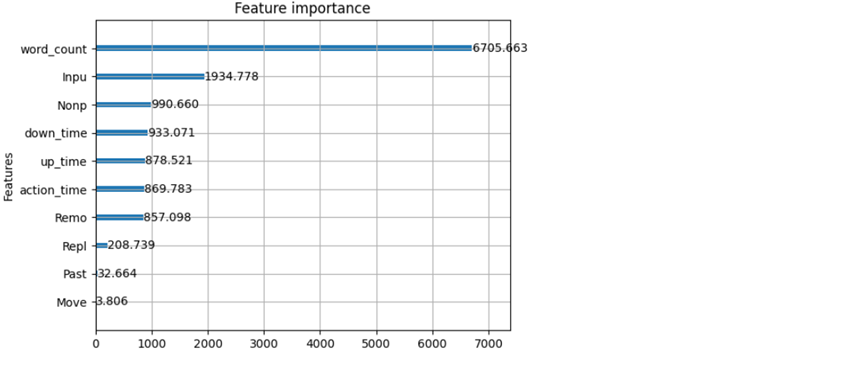

Since action-related features, let's see the relationship between down/up_time and the score.  
The result of corr() shows positive for up_time, which means the bigger and bigger up_time becomes the better score becomes, and on the contrary down_time shows negative relationship, which means the smaller and smaller down_time becomes the better score becomes.  
After all, we could understand "it is important to consider the contents in advance, start writing as soon as possible and write as many words as possible fully using the given time"...which also make sense.

動作としてdown_time、up_timeもそれなりに重要なようですので、少しスコアとの相関関係を見てみます。  
corr()で相関を見ますと、up_timeはプラスの値なので大きくなるほどスコアが良くなる、逆にdown_timeはマイナス値なので小さくなるほどスコアは良くなるようです。  
要は、事前に書くことを頭の中で整理しておいて始まったらすぐに書き始める、終わりも時間いっぱい使ってなるべく多くの文章を書く、ということが大事なようです。これもまぁ、納得できますね。

<Axes: >

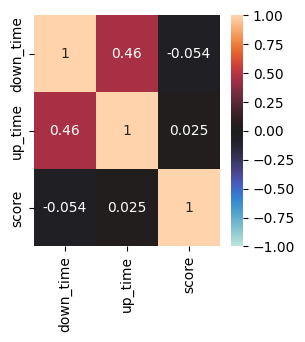

In [9]:
temp = train[["id","down_time"]].groupby("id", as_index=False).min()
temp_train = train[["id","up_time"]].groupby("id", as_index=False).max()
temp = pd.merge(temp, temp_train, on="id", how="left")
temp = pd.merge(temp,df_scores, on="id", how="left")
temp = temp.drop(columns="id")
train_cor = temp.corr()
plt.figure(figsize=(3,3))
sns.heatmap(train_cor, vmax=1,vmin=-1,center=0,annot=True)

# (2) Add Typing info

Next, let's use contents-related features as well. We'd like to see "up_event" first, which means "what key was pressed".

次に、入力内容そのものも使ってみたいと思います。少し例外はありますが、概ねdown_eventとup_eventは一致していますので、up_eventの中身を見てみます。要は「何を押したか」ですね。

In [10]:
print(train["up_event"].unique())

['Leftclick' 'Shift' 'q' 'Space' 'Backspace' '.' ',' 'Enter' 'ArrowLeft'
 "'" ';' 'ArrowRight' '-' '?' 'Tab' '"' 'ArrowUp' 'ArrowDown' 'm'
 'Rightclick' 'i' 'o' 't' '=' 'a' 'CapsLock' 'Control' 'c' 'v' '/'
 'Delete' ':' 'z' '[' '$' '(' ')' '+' 'Home' 'End' '\\' 'Meta' '*' '&'
 'AudioVolumeMute' 'x' '!' 'Insert' 'MediaPlayPause' 'w' 'NumLock' '%' 'V'
 'b' '>' 'Alt' 'AudioVolumeUp' 'ContextMenu' 'AudioVolumeDown' 'n' 'e' '<'
 'PageDown' ']' 'Middleclick' '@' 'F12' 'u' 'j' 's' '\x96' 'Dead' 'y' '{'
 'ScrollLock' '¿' 'p' 'Process' '}' 'MediaTrackPrevious' 'MediaTrackNext'
 'F3' '^' 'Unidentified' 'Cancel' 'h' '2' 'd' 'r' '`' '\x9b' 'f' 'g' '#'
 '~' 'PageUp' 'l' 'T' 'A' 'S' 'ModeChange' '_' 'Escape' 'F11'
 'Unknownclick' 'AltGraph' 'F10' 'F15' 'Clear' 'OS' 'C' 'Ä±' 'M' '|'
 'â\x80\x93' '0' '1' '5' '\x97' 'Ë\x86' '¡' '\x80' 'Â´' 'Å\x9f' 'F2' 'ä'
 'F1' 'k' 'Pause' 'F6']


We can see many outputs, but let's narrow down to Space, Backspace, Delete, Control and Enter, which seem related to sentence modification.  
Just FYI, all inputted keys are anonymized as "q" so that we cannot use the sentences itself for prediction purpose.  
But anyway, the public score was improved from **0.726** to **0.718**.

かなり色々出てきましたが、なんとなくスコアに影響しそうな（修正作業等に使われそうな）Space, Backspace, Delete, Control, Enterに絞って使ってみます。  
なお、このコンペでは出来上がったエッセイの文章そのもので予測がされないよう基本的に入力された文字は「q」に匿名化されています。 
これらの総数を特徴量に加えたところ、Public Scoreは**0.726**⇒**0.718**へと少し改善しました。

In [11]:
# df["Space"]     = df["up_event"].apply(lambda x:1 if x=="Space" else 0)
# df["Backspace"] = df["up_event"].apply(lambda x:1 if x=="Backspace" else 0)
# df["Delete"]    = df["up_event"].apply(lambda x:1 if x=="Delete" else 0)
# df["Control"]   = df["up_event"].apply(lambda x:1 if x=="Control" else 0)
# df["Enter"]     = df["up_event"].apply(lambda x:1 if x=="Enter" else 0)
# df_temp   = df[["id","Space","Backspace","Delete","Control","Enter"]].groupby("id").sum()
# df_train  = pd.merge(df_train, df_temp, on="id", how="left")

# (3) Add Cursor_position info

Next, let's use cursor_position. To be honest, my initial thought was "why the location of cursor on the screen impact to the score, huh?", but I noticed the last(max) position could mean the total volume of the essay or something like and hence this may be an important feature.  
The result is, public score wa improved from **0.718** to **0.699**, which is quite big improvement.

次に、これまで使ってなかったcursor_positionを使ってみます。正直、「画面上のカーソルの位置なんて関係ないよね」と思って使わなかったのですが、Max値は書き終えたエッセイのボリュームをほぼ意味するでしょうし、平均値も文章作成の進捗等に関係したりと重要な意味を持つのだと思います。ついでに、単語数の平均値もここで追加しておきます。  
結果は、**0.718**→**0.699**と大きく改善しました。

In [12]:
#df_temp   = df[["id","cursor_position",]].groupby("id").max()
#df_temp   = df[["id","cursor_position",]].groupby("id").mean()
#df_temp   = df[["id","word_count",]].groupby("id").mean()

# (4) Add average word length

As we saw in the above, it seems contents-related features could have impact rather than action-related. For attemption, let's use the average word length, thenscore will be improved to **0.690**. Just in case, the below logic is not necessarily exact average length, since we do not know exact length of the essay.

これまで見てきたように、どうやら動作そのものというよりエッセイの中身に関係する特徴量を使うと効果がありそうです。試しに、単語の平均的な長さというものを足してみますとスコアは**0.690**へと改善しました。なお、正確ではないのですが、ここではカーソル位置のMax値を文章の長さとしそこから空白を除いて単語数で割ったものを単語の平均的な長さとして使いました。

In [13]:
#df_train["avg_word_len"] = (df_train["cursor_position_x"]-df_train["Space"]) / df_train["word_count_x"]

# (5) Add "how difficult the essay seems"

Next, we'd like to use the essay sentences itself since it may be better than action-related.  
But, as I mentioned, all characters are anonymized as "q" and hence it is impossible to see the sentences. However, below-linked wonderful notebook challenged to restore the original essay as much as possible, thus I'd like to try something based on that. FYI, it takes a bit long time to restore the original sentences, and hence I'd like to use the pre-restored dataset. When you try by yourself, please "add" the dataset in advance as follows.


ここまで見てきたように文章そのものに関係する特徴量が有効そうですので、ここで文章そのものを使ってみます。  
とはいえ、上述したように、このコンペではエッセイの文章そのものが予測に使われないように全て「q]で匿名化されているので、文章そのものが入手できません。しかしながら、以下リンク先の素晴らしいNotebookで動作内容を元にエッセイの復元に調整した方がいらっしゃるので、これに基づいて復元された文章を元に少し試してみたいと思います。なお、このリンク先のCodeで文章を復元するには少し時間を要します。訓練データについては復元済みのものがDatasetに公開されているので、そちらを使わせてもらいました。ご自身で試される場合は、以下要領で事前にデータをAddしておいてください。

Credit to this wonderful notebook : https://www.kaggle.com/code/jasonheesanglee/updated-22-54-acc-revealing-hidden-words

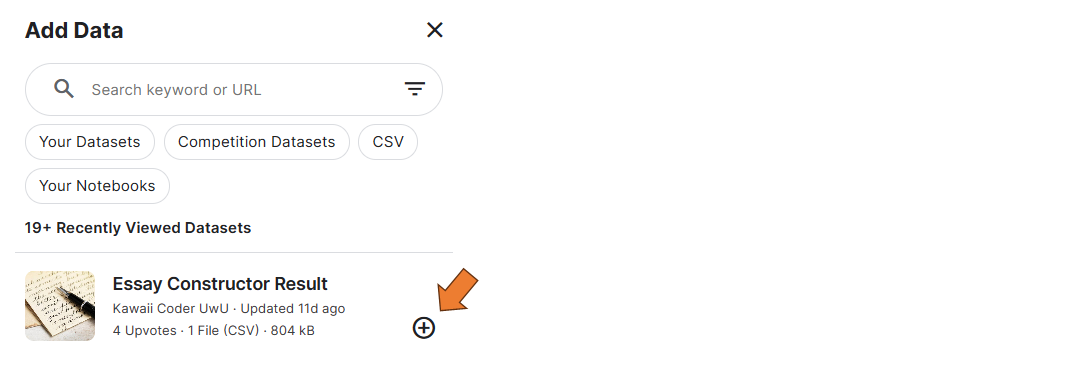

In [14]:
essay = pd.read_csv('/kaggle/input/essay-constructor-result/Essay Constructor Result.csv')
essay

,id,essay
0,001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...
1,0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq..."
2,0042269b,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...
3,0059420b,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...
4,0075873a,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq..."
...,...,...
2466,ffb8c745,"qq qqqqq'q qqqqqqq, qqq'q qqqqq q qqqq qq..."
2467,ffbef7e5,"qqqq qqqqqq qqqqq qq qqqqq qqqqq, qq qq q qqqq..."
2468,ffccd6fd,qqqqqq qqqq q qqqqqqq qqqqqqqqq qq qqqqqq qqqq...
2469,ffec5b38,"qqqqqqqqqq qqqqqqq, qqqqqq qqqq qqqqq qqqq qqq..."


You may feel "how we could use the sentences, though all characters are anonymized as q?". You are correct, we can never see the original sentences itself.  
However, when I see and compared the highest score essay and the lowest score essay, I feel the highest score one looks better than the lowest. I guess the reason would be that "**long-character word seems to be used**", which make the sentences look DIFFICULT or Sotisficated.  
This is purely my personal impression, but based on this impression, would like to try to add new feature "**difficulty**" which is "get more bonus if long word is used".   


元の文章が分からないのにどうやって使うの？という点ですが、確かに全て「q」となっているので、文章の内容は全く分かりません。
ただ、最高点のエッセイと最低点のエッセイを見比べてみると、最高点の文章のほうが最低点の文章より良く見えるような気がします。最高点の文章のほうが「**文字数の多い単語**」が使われているような気がしますし、それによって何となく文章がムズカしい（高尚な）文章に見えるのではないでしょうか。  
完全に個人の感想ですが、この仮説に基づいて、「長い単語を使うと加点」される**difficulty**という特徴量を作ってみます。  

・ **1～4character word : 0(zero) point**  
・ **5･6 character word : 1 point**  
・ **7･8 character word : 3 point**  
・ **9+  character word   : 5 point**  

In [15]:
pd.set_option("display.max_colwidth", 200)
temp = pd.merge(essay, df_scores, on="id", how="left")
print("Score 6.0 :   ", temp.loc[temp["id"]=="0042269b", "essay"])
print("Score 0.5 :   ", temp.loc[temp["id"]=="c3663a2d", "essay"])
pd.set_option("display.max_colwidth", 50)

Score 6.0 :    2    qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq qqqqqqqq qqq qqqqqqqqqqq qqq q qqqqqqq qq qqqqqqqq qq qqqqqqqq qqqqqqq, qqqq qq qqqqqqqqqq qq . qq qqqqqqq, qqqqqqqqqqq qqqqq qqq qqqqqqqq qqqqqqq, qq...
Name: essay, dtype: object
Score 0.5 :    1848    qq qqqq qqq q qqq qq qqqqqqq qq qqqqq qqqqqqqqqqq qqqqqq qqqqqq qqqqqqq qqq qq qqq qqqqqqqqqq qq qqq qqqqqq. qqq qqqqqqq qqq qqq qq qqq qqqq qqqq q qqqq qqqq qqqqqq qqqqq. qq qqqqqq qqqqqqq qqqqqq...
Name: essay, dtype: object


In [16]:
def text_change(df):
    bf = []
    af = []
    for change in df['text_change']:
        if '=>' in change:
            bf.append(change.split('=>')[0])
            af.append(change.split('=>')[1])
        else:
            bf.append('-')
            af.append(change)
    return pd.Series(bf), pd.Series(af)

train['before_change'], train['after_change'] = text_change(train)
train = train.drop(columns='text_change')
df_test['before_change'], df_test['after_change'] = text_change(df_test)
df_test = df_test.drop(columns='text_change')

def decoder(df, column):
    decoded = []
    for i in tqdm(df[column]):
        try:
            if len(unidecode(i))==0:
                decoded.append('')
            elif len(i) != len(unidecode(i)):
                decoded.append(i[0])
            else:
                decoded.append(unidecode(i))
        except AttributeError:
            decoded.append(i)
    df[f'decoded_{column}'] = pd.Series(decoded)
    return df

import unicodedata
from unidecode import unidecode

dec_col = ['down_event', 'up_event', 'before_change','after_change']
for i in dec_col:
    decoder(train, i)
    decoder(df_test, i)

tr_down_event = [i for i in train['decoded_down_event'].unique().tolist() if 'q' not in i] + ['q']
tr_up_event = [i for i in train['decoded_up_event'].unique().tolist() if 'q' not in i] + ['q']

te_down_event = [i for i in df_test['decoded_down_event'].unique().tolist() if 'q' not in i] + ['q']
te_up_event = [i for i in df_test['decoded_up_event'].unique().tolist() if 'q' not in i] + ['q']

all_event = list(set(tr_down_event + te_down_event + tr_up_event + te_up_event))

useless = ['AudioVolumeMute', 'AudioVolumeDown', 'MediaPlayPause', 'AudioVolumeUp', 'ModeChange', 'ContextMenu', 'Process', 'Middleclick', 'ScrollLock','MediaTrackNext', 'MediaTrackPrevious', 'AltGraph', 'NumLock']
list_of_special_actions = [i for i in all_event if (len(i) > 1) & (i !="A'") & (i not in useless)]
list_of_inputs = [i for i in all_event if (len(i)==1) or (i=="A'")]

  0%|          | 0/8405898 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8405898 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8405898 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8405898 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
def revealing_text(df):
    string = '' # empty string to add or edit the input sequence
    cursor = 0 # position of cursor
    shift_timer = 0 # Recording `up_time` for `Shift` key if `down_time` != `up_time` 
    decoded_num = 0 # Counting the number of decoded char
    INSERT = False # Switch for `Insert` key. 
    CAPSLOCK = False # Switch for `CapsLock` key.
    SHIFT = False # Switch for `Shift` key 
    
    '''
    This function converts the list of input sequence to a full essay.
    - OCT 21 2023 Still in progress
    
    Thank you @kawaiicoderuwu for thoughts on Shift, however... it didn't work...
    I have still implemented the idea.
    Shift reconstructed based on:
    https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/discussion/447735#2487004
    
    '''
    # Checking whether the reconstruction was done well with comparing the `text_change` column.
    YES = 0 
    NO = 0
    sp_character_dict = {';':':',
                         "'": '"',
                        ',':'<',
                        '.':'>',
                        '/':'?',
                        '\\': '|',
                         '1':'!',
                         '2':'@',
                         '3':'#',
                         '4':'$',
                         '5':'%',
                         '6':'^',
                         '7':'&',
                         '8':'*',
                         '9':'(',
                         '0':')',
                         '-':'_',
                         '=':'+',
                         '`':'~',
                         '[':'{',
                         ']':'}'
                        }
    
    
    def sentence_splitter(string, char_per_line=140):
        '''
        This function will separate the sentence based on the size of prompt.
        
        Input : 
        string : Sentence
        char_per_line : Number of characters in one line (not sentence).
        Output :
        List of splitted sentences.
        
        I have manually counted the number of characters per line. 
        Based on the prompt depicted in Competition Overview - Data Collection Procedure.
        www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/overview/data-collection-procedure
        '''
        each = []
        remaining_words = len(string) % char_per_line
        full_line = len(string) // char_per_line
        crsr = 0
        for i in range(full_line):
            if crsr == 0:
                each.append(string[:char_per_line])
                crsr = char_per_line
            else:
                each.append(string[crsr:(i+1)*char_per_line])
                crsr = crsr + char_per_line
        each.append(string[:-len(string)%char_per_line +1])
        return each
    
    def enter_splitter(list_line):
        '''
        This function will split the sentence if it contains \n (Enter) into 2 separate string.
        
        Input : 
        list_line : Sentences in list (connected with `sentence_splitter` function in this notebook.)
        Output : 
        enter_splitted : List of splitted sentence.
        '''
        enter_splitted = []
        for line in list_line:
            if '\n' in line:
                for lin in line.split('\n'):
                    if lin != line.split('\n')[-1]:
                        enter_splitted.append(lin+'\n')
                    else:
                        enter_splitted.append(lin)
            else:
                enter_splitted.append(line)
        return enter_splitted
    
    for row_num in range(df.shape[0]): # iterates over each row in df.        
        # I was lazy to type `df['down_event'].iloc[row_num]` all the time.
        action = df['decoded_down_event'].iloc[row_num]
        if action in useless:
            continue
        if action == ' ':
            decoded_num = decoded_num + 1
        # I used `df['cursor_position'].iloc[row_num]` everywhere in the code
        # and I think not putting this in a variable was the problem.
        cursor_now = df['cursor_position'].iloc[row_num]
        
        # Config... kinda?
        
        if action == 'Insert':
            if INSERT == True:
                INSERT = False
                continue
            else:
                INSERT = True
                continue
                
        elif action == 'CapsLock':
            if CAPSLOCK == True:
                CAPSLOCK = False
                continue
            else:
                CAPSLOCK = True
                continue
        
        if action == 'Shift' and (df['down_time'].iloc[row_num] != df['up_time'].iloc[row_num]):
            shift_timer = df['up_time'].iloc[row_num]
            SHIFT = True
            continue
            
        if shift_timer != 0:
            shift_timer = 0
            SHIFT = False
            
        '''
        I have added two if-statements above to be prepared for the occasion
        where `down_time` and `up_time` is different for `Shift`.
        As all `down_time` and `up_time` are the same in training data,
        these conditions wouldn't be activated.
        '''


        if shift_timer == 0:
            if action == 'Shift':
                SHIFT = True
                continue

            elif df['decoded_down_event'].iloc[row_num-2] == 'Shift':
                SHIFT = False
        
        if row_num == 0:
            cursor = 0
            
        else:
            cursor = df['cursor_position'].iloc[row_num-1]
        
                
        ################################################################
        ################################################################
        
        # Cursor position
        

        if (action == 'Tab')&(row_num!=0):
            if df['decoded_down_event'].iloc[row_num-1] == 'Alt':
                '''
                Ignores `Alt + Tab`, which is the window switching keyboard shortcut. 
                Not sure if it is in the sequence, but I just added it.
                '''
                continue


            if cursor == len(string):
                '''
                Adding `\t` for `Tab` at the end of the string.
                '''
                string = string + '\t'
                cursor = cursor_now
                continue


            else:
                '''
                Adding `\t` for `Tab` where the cursor is positioned at.
                '''
                string = string[:cursor] + '\t' + string[cursor:]
                cursor = cursor_now
                continue
            
                    
        ################################################################
        ################################################################
        
        # Remove/Cut
        if df['activity'].iloc[row_num] == 'Remove/Cut':
            '''
            For Backspace & Delete, we can only consider when the activity == 'Remove/Cut'.
            '''
            if action == 'Backspace':
                
                # When the cursor is at the end of the string.
                if cursor == len(string):
                    # Simply removes the last character.
                    string = string[:-1]
                    # The cursor repositions as the length of the string decreases.
                    cursor = cursor_now
                    continue
                    
                elif cursor == 0: 
                    '''
                    There is no point of `Backspace` when the cursor is at the beginning of the whole essay.
                    '''
                    cursor = cursor_now
                    continue
                else: 
                    '''
                    When the cursor is in the middle of the string.
                    Removes the last character before the cursor position and add the remaining string.
                    '''
                    string = string[:cursor-1] + string[cursor:] 
                    # The cursor repositions as the length of the string decreases.
                    cursor = cursor_now
                    continue
                    
            elif action == 'Delete': 
                '''
                There is no point of `Delete` when the cursor is at the end of the sentence.
                '''
                if cursor == len(string): 
                    cursor = cursor_now
                    continue
                    
                # When the cursor is positioned at the beginning of the essay.
                elif cursor == 0: 
                    '''
                    Simply deletes the first character of the whole essay.
                    '''
                    string = string[1:] 
                    cursor = cursor_now
                    continue
                    
                else: 
                    '''
                    When the cursor is in the middle of the sentence.
                    A character right after the cursor position is removed,
                    then it is added to the string before the cursor.
                    '''
                    string = string[:cursor] + string[cursor+1:] 
                    '''
                    Cursor doesn't move, check the discussion below.
                    https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/discussion/448180#2488038
                    '''
                    cursor = cursor_now
                    continue
            
        ################################################################
        ################################################################
        
        elif df['activity'].iloc[row_num].startswith('Move'):
            act = df['activity'].iloc[row_num].split()
            before_start = int(act[2][1:-1])
            before_end = int(act[3][0:-1])
            after_start = int(act[5][1:-1])
            after_end = int(act[6][0:-1])
        
            string_to_be_moved = string[before_start:before_end]
            string = string[:before_start] + string[before_end:after_start] + string_to_be_moved + string[after_end:]
            cursor = cursor_now
            continue
            
        ################################################################
        ################################################################
        
        elif df['activity'].iloc[row_num] == 'Paste':
            string = string[:cursor] + df['decoded_after_change'].iloc[row_num] + string[cursor:]
            cursor = cursor_now
            continue
            
        ################################################################
        ################################################################
        
        elif df['activity'].iloc[row_num] == 'Input':
            input_ = df['decoded_after_change'].iloc[row_num]
            if input_ in list_of_inputs:                
                # When the `Insert` switch is off.
                if INSERT == False:     
                    # When the `CapsLock` switch is off.
                    if CAPSLOCK == False: 
                        # When the cursor is at the end of the string.
                        if cursor == len(string): 
                            # When Shift switch is off
                            if SHIFT == False: 
                                '''
                                The input is simply added at the end of the string.
                                '''
                                string = string + input_
                                cursor = cursor_now
                                continue
                            
                            else: # When Shift switch is on.
                                if input_.isalpha():
                                    '''
                                    The capitalized input is added at the end of the string.
                                    '''
                                    string = string + input_.upper()
                                    cursor = cursor_now
                                    continue
                                    
                                elif input_ in sp_character_dict.keys(): 
                                    '''
                                    The keys are removed, replaced with the values. (Based on my keyboard) 
                                    But I think the values are already in the sequence.
                                    '''
                                    string = string + sp_character_dict.get(input_) 
                                    cursor = cursor_now
                                    continue
                                    
                                else:
                                    string = string + input_
                                    cursor = cursor_now
                                    continue
                                    
                        else: 
                            '''
                            When the cursor is not at the end of the string.
                            '''
                            if SHIFT == False:
                                '''
                                The input is added at the cursor position.
                                '''
                                string = string[:cursor] + input_ + string[cursor:] 
                                cursor = cursor_now
                                continue
                            else:
                                if input_.isalpha():
                                    string = string[:cursor] + input_.upper() + string[cursor:] 
                                    cursor = cursor_now
                                    continue
                                    
                                elif input_ in sp_character_dict.keys(): 
                                    string = string[:cursor] + sp_character_dict.get(input_)  + string[cursor:]
                                    cursor = cursor_now
                                    continue
                                    
                                else:
                                    string = string[:cursor] + input_ + string[cursor:] 
                                    cursor = cursor_now
                                    continue
                    else: 
                        '''
                        When `CapsLock` switch is on.
                        When the cursor is at the end of the essay.
                        '''
                        if cursor == len(string): 
                            if input_.isalpha():
                                '''
                                The alphabets typed after this loop will be in capitals until the CapsLock is turned off.
                                '''
                                string = string + input_.upper() 
                                cursor = cursor_now
                                continue
                                
                            else:
                                '''
                                As the `CapsLock` is only applied to the alphabets, 
                                no special action is need for non-alphabets.
                                '''
                                string = string + input_ 
                                cursor = cursor_now
                                continue
                                
                        else: 
                            '''
                            When the cursor is positioned in the middle of the string.
                            A caplitalized alphabet is added at the cursor position.
                            '''
                            string = string[:cursor] + input_.upper() + string[cursor:] 
                            cursor = cursor_now
                            continue


                else: # When `Insert` switch is on.
                    '''
                    I will skip the explanations for `CapsLock` and focus more on `Insert`
                    '''
                    if CAPSLOCK == False: 
                        if cursor == len(string):
                            if SHIFT == False:
                                string = string + input_
                                cursor = cursor_now
                                continue
                                
                            else:
                                if input_.isalpha():
                                    string = string + input_.upper()
                                    cursor = cursor_now
                                    continue
                                    
                                elif input_ in sp_character_dict.keys():
                                    string = string + sp_character_dict.get(input_)
                                    cursor = cursor_now
                                    continue
                                    
                                else:
                                    string = string + input_
                                    cursor = cursor_now
                                    continue
                                    
                        else: # When the cursor is in the middle of the string.
                            if SHIFT == False:
                                string = string[:cursor] + input_ + string[cursor+1:] 
                                cursor = cursor_now
                                continue
                                
                            else:
                                if input_.isalpha()==True:
                                    string = string[:cursor] + input_.upper() + string[cursor+1:] 
                                    cursor = cursor_now
                                    continue
                                    
                                elif input_ in sp_character_dict.keys():
                                    string = string[:cursor] + sp_character_dict.get(input_) + string[cursor+1:] 
                                    cursor = cursor_now
                                    continue
                                    
                                else:
                                    string = string[:cursor]+ input_ + string[cursor+1:]
                                    cursor = cursor_now
                                    continue
                                    
                            '''        
                            It takes full string before the cursor position
                            Add input
                            Then add removes the first character of the remaining string and add it to the previous string.
                            This logic applies to the whole `else` statement, so I will skip.
                            '''
                        
                    else: # When CapsLock is on.
                        if cursor == len(string):
                            if input_.isalpha():
                                string = string + input_.upper()
                                cursor = cursor_now
                                continue
                                
                            else: # When the action is not alphabet.
                                if SHIFT==False:
                                    string = string + input_
                                    cursor = cursor_now
                                    continue
                                    
                                elif input_ in sp_character_dict.keys(): 
                                    string = string + sp_character_dict.get(input_)
                                    cursor = cursor_now
                                    continue
                                else:
                                    string = string + action
                                    cursor = cursor_now
                                    continue
                        else:
                            if input_.isalpha()==True:
                                string = string[:cursor] + input_.upper() + string[cursor+1:]
                                cursor = cursor_now
                                continue
                                
                            else:
                                if SHIFT==False:
                                    string = string[:cursor] + input_ + string[cursor+1:]
                                    continue
                                    
                                elif input_ in sp_character_dict.keys():
                                    string = string[:cursor] + sp_character_dict.get(input_) + string[cursor+1:] 
                                    cursor = cursor_now
                                    continue
                                    
                                else:
                                    string = string[:cursor] + input_ + string[cursor+1:]
                                    cursor = cursor_now
                                    continue

            ################################################################

            if action == 'Space': # When the `Space` was inserted
                if cursor == len(string):
                    string = string + input_
                    cursor = cursor_now
                    continue
                
                else:
                    if INSERT == False: 
                        '''
                        When `Insert` switch is off and the cursor is not positioned at the end of the sentence.
                        '''
                        string = string[:cursor] + input_ + string[cursor:]
                        cursor = cursor_now
                        continue
                    
                    else: 
                        '''
                        When `Insert` switch is on and the cursor is not positioned at the end of the sentence.
                        '''
                        string = string[:cursor] + input_ + string[cursor+1:]
                        cursor = cursor_now
                        continue

            ################################################################

            elif action == 'Enter': # When the `Enter` was inserted
                if cursor == len(string):
                    string = string + input_
                    cursor = cursor_now
                    continue
                    
                else:
                    string = string[:cursor] + input_ + string[cursor:]
                    cursor = cursor_now
                    continue
        
        ################################################################
        ################################################################
        
        
        elif (df['activity'].iloc[row_num] == 'Replace') & (df['decoded_before_change'].iloc[row_num]!='-'): 
            '''
            When the `activity` column is set as `Replace`.
            '''    
            before = df['decoded_before_change'].iloc[row_num].strip() # string to be replaced.
            after = df['decoded_after_change'].iloc[row_num].strip() # string replaced.
            
            string = string[:cursor-len(before)-1] + after + string[cursor:] 
            cursor = cursor_now
            continue
            
    if len(string.split()) - decoded_num == df['word_count'].iloc[row_num]:
        '''
        Check if the replace was well-performed. 
        Which most probably means my reconstruction worked well.
        '''
        YES = YES+1
    else: 
        '''
        My reconstruction didn't work well.... omg... Need to work harder.
        '''
        NO = NO+1
    return string, YES, NO

In [18]:
def essay_difficulty(df):
    df['token'] = [word_tokenize(p) for p in df["essay"]]
    df['token_len'] = df['token'].apply(lambda x : list(len(word) for word in x))
    df['verylong']  = df['token_len'].apply(lambda x : sum(c>=9 for c in x))
    df['long']      = df['token_len'].apply(lambda x : sum(c==7 or c==8 for c in x))
    df['mid']       = df['token_len'].apply(lambda x : sum(c==5 or c==6 for c in x))
    df['difficulty'] = df['verylong']*5 + df['long']*3 + df['mid']*1
    
    df['long_words'] = df['verylong']+df['long']
    
    return df

In [19]:
"""
essay = essay_difficulty(essay)
x = feature_eng(train)
x = pd.merge(x, essay[["id","difficulty"]], on ="id", how="left")
x = x.drop(columns="id")
y= df_scores["score"].values

model_lgbm = lgbm.LGBMRegressor(n_estimators = 500, metric="rmse")
model_lgbm.fit(x, y)
lgbm.plot_importance(model_lgbm, importance_type="gain")
"""

'\nessay = essay_difficulty(essay)\nx = feature_eng(train)\nx = pd.merge(x, essay[["id","difficulty"]], on ="id", how="left")\nx = x.drop(columns="id")\ny= df_scores["score"].values\n\nmodel_lgbm = lgbm.LGBMRegressor(n_estimators = 500, metric="rmse")\nmodel_lgbm.fit(x, y)\nlgbm.plot_importance(model_lgbm, importance_type="gain")\n'

If you run the above code after removing Comment-out, you will see the result of feature_importance of LGBM. As you can see, the newly-added "difficulty" came to the top of the importance. I'd expect this new feature could much contribute to the score improvement, however, actual improvement of public score was from **0.690** to **0.683**.

上記セルのコメントアウトを外して、実行すると学習結果は以下のようになり、新たに追加した「difficulty」がいきなりFeature_importanceのトップに躍り出ました。結構効果があったのでしょうか。ただ、Public Scoreは**0.690→0.683**へと、さほど大きな改善幅ではありませんでした。

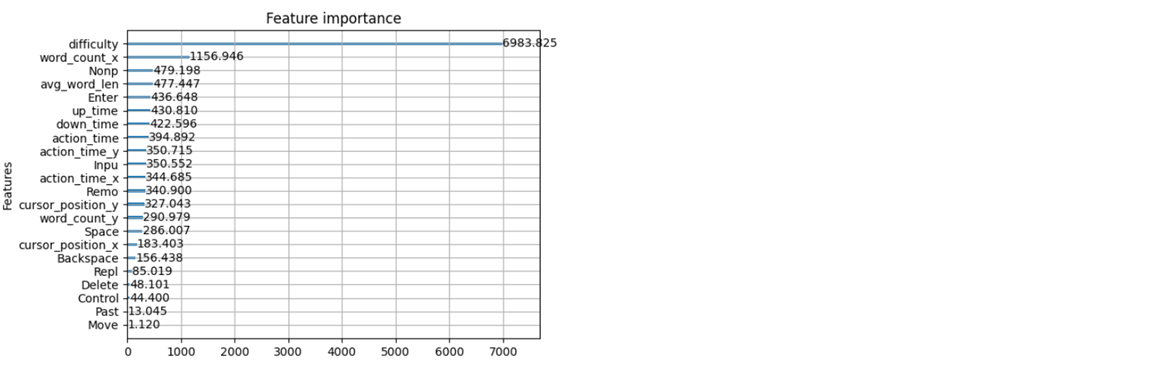

# (6) Add "write the essay while thinking?"

Lastly, would like to get back to "action-related" again.  
As we saw in the above (1), if "consider the contents well in advance and write as many as possible" could lead to better score, then in other words, "input words slowly while considering and considering" might lead to worse score. To verify this idea, I'd like to add new feature the time siff between previous action end and nect action start.  
The result is the score was improved to **0.678**. 

最後に、再度「動作」に戻りたいと思います。上記(1)で見たように、「事前に内容をよく考えておいて、始まったらなるべくいっぱい書く」というのが良い点数に繋がるのであれば、逆に言えば、考え考えしながらゆっくり文字を打つようなケースは採点が悪くなるのではないでしょうか。これを検証するため、以下のように「前の動作が終わった後、次の動作を始めるまでの時間」を表す特徴量を追加してみます。  
結果としては、**0.678**へと改善しました。

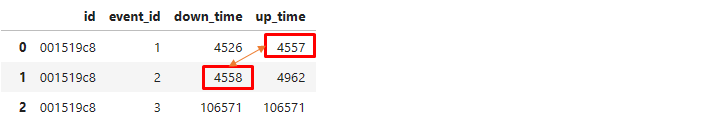

In [20]:
# ----->Into def feature_eng(df)

#df['diff'] = df['down_time']-df['up_time'].shift(1)
#df['diff'] = df['diff'].apply(lambda x : 0 if x<0 else x)
#df_temp   = df[["id","diff",]].groupby("id").mean()
#df_train  = pd.merge(df_train, df_temp, on="id", how="left")

# ----->Into def essay_difficulty(df)
#df['long_words'] = df['verylong']+df['long']


After all, below is the consolidated feature-engineering def.  
For easier understanding, I simply consolidate the avobe introduced codes. Sorry for the redundant code!

ということで、これまで見て来た特徴量をまとめたのが以下です。  
（分かりやすくするため、上記の特徴量を単純に合わせただけにしました。For文を使うともっと短く記述できると思います。冗長な記述で申し訳ありません）

In [21]:
def feature_eng(df) :
        
    df_train  = df[["id","down_time",]].groupby("id").min()
    df_temp   = df[["id","up_time",]].groupby("id").max()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")
    
    df_temp   = df[["id","action_time",]].groupby("id").mean()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")    
    df_temp   = df[["id","action_time",]].groupby("id").sum()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")
    df_temp   = df[["id","action_time",]].groupby("id").max()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")
    
    df_temp   = df[["id","word_count",]].groupby("id").max()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")
    df_temp   = df[["id","word_count",]].groupby("id").mean()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")    
    
    df_temp   = df[["id","cursor_position",]].groupby("id").max()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")
    df_temp   = df[["id","cursor_position",]].groupby("id").mean()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")      
    
    df["activity"] = df["activity"].str[:4]
    df["Inpu"] = df["activity"].apply(lambda x:1 if x=="Inpu" else 0)
    df["Move"] = df["activity"].apply(lambda x:1 if x=="Move" else 0)
    df["Nonp"] = df["activity"].apply(lambda x:1 if x=="Nonp" else 0)
    df["Past"] = df["activity"].apply(lambda x:1 if x=="Past" else 0)
    df["Remo"] = df["activity"].apply(lambda x:1 if x=="Remo" else 0)
    df["Repl"] = df["activity"].apply(lambda x:1 if x=="Repl" else 0)
    df_temp   = df[["id","Inpu","Move","Nonp","Past","Remo","Repl"]].groupby("id").sum()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")
    
    df["Space"]     = df["up_event"].apply(lambda x:1 if x=="Space" else 0)
    df["Backspace"] = df["up_event"].apply(lambda x:1 if x=="Backspace" else 0)
    df["Delete"]    = df["up_event"].apply(lambda x:1 if x=="Delete" else 0)
    df["Control"]   = df["up_event"].apply(lambda x:1 if x=="Control" else 0)
    df["Enter"]     = df["up_event"].apply(lambda x:1 if x=="Enter" else 0)
    df_temp   = df[["id","Space","Backspace","Delete","Control","Enter"]].groupby("id").sum()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left") 
    
    df_train["avg_word_len"] = (df_train["cursor_position_x"]-df_train["Space"]) / df_train["word_count_x"]
    
    df['diff'] = df['down_time']-df['up_time'].shift(1)
    df['diff'] = df['diff'].apply(lambda x : 0 if x<0 else x)
    df_temp   = df[["id","diff",]].groupby("id").mean()
    df_train  = pd.merge(df_train, df_temp, on="id", how="left")
            
    return df_train

In [22]:
#def essay_difficulty(df):
#    df['token'] = [word_tokenize(p) for p in df["essay"]]
#    df['token_len'] = df['token'].apply(lambda x : list(len(word) for word in x))
#    df['verylong']  = df['token_len'].apply(lambda x : sum(c>=9 for c in x))
#    df['long']      = df['token_len'].apply(lambda x : sum(c==7 or c==8 for c in x))
#    df['mid']       = df['token_len'].apply(lambda x : sum(c==5 or c==6 for c in x))
#    df['difficulty'] = df['verylong']*5 + df['long']*3 + df['mid']*1
#    
#    df['long_words'] = df['verylong']+df['long']
#            
#    return df

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

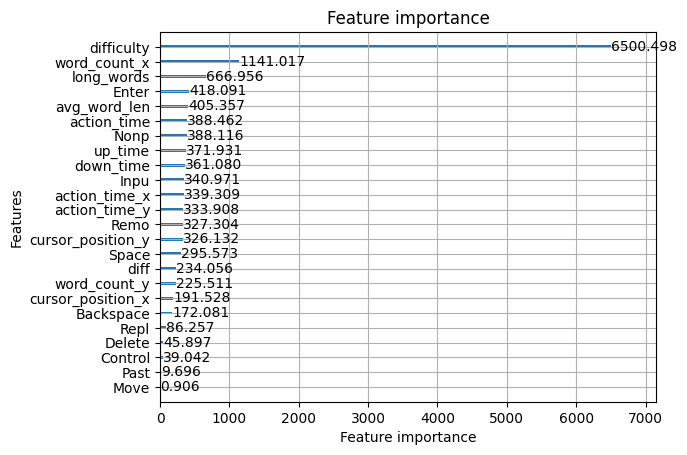

In [23]:
model_lgbm = lgbm.LGBMRegressor(n_estimators = 500, metric="rmse")

essay = essay_difficulty(essay)
x = feature_eng(train)
x = pd.merge(x, essay[["id","difficulty", "long_words"]], on ="id", how="left")
x = x.drop(columns="id")
y= df_scores["score"].values

model_lgbm.fit(x, y)
lgbm.plot_importance(model_lgbm, importance_type="gain")

# (7) Submission

In [24]:
train_revealed = pd.DataFrame({'id':[], 'essay':[]})
# counter = 0
YESSSS = 0
NOOOOO = 0
for i in tqdm(df_test['id'].unique().tolist()):
    
    df = df_test[df_test['id']==i] 
    df_string, YES, NO = revealing_text(df)
    YESSSS = YESSSS + YES
    NOOOOO = NOOOOO + NO
    temp_df = pd.DataFrame({'id':[i], 'essay':[df_string]})
    train_revealed = pd.concat([train_revealed, temp_df], axis=0)

try:
    yes_no_ratio = YESSSS/(YESSSS+NOOOOO)
    print(f'Success Rate = {yes_no_ratio:.2f}')

except:
    pass

display(train_revealed.iloc[0])

  0%|          | 0/3 [00:00<?, ?it/s]

Success Rate = 1.00


id       0000aaaa
essay            
Name: 0, dtype: object

In [25]:
train_revealed = essay_difficulty(train_revealed)
test = feature_eng(df_test)
test = pd.merge(test, train_revealed[["id","difficulty", "long_words"]], on ="id", how="left")
test = test.drop(columns="id")
pred = model_lgbm.predict(test)
submission = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv')
submission['score']=pred
submission.to_csv("submission.csv", index=False)
submission

,id,score
0,0000aaaa,0.918443
1,2222bbbb,1.092455
2,4444cccc,0.966665
